<a href="https://colab.research.google.com/github/emmandecena/meee/blob/main/Copy_of_EE_298_Z_SRU_Assignment_3_AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Emmanuel Decena - ME EE** - Deep Learning Assignment 3

**AdaIN**

Implement the style transfer paper Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization by Huang and Belognie on MNIST (target) and SVHN (source style)
VGG can be replaced by a much smaller CNN AE

### Libraries

In [61]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dense, Add, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K
import datetime, os, numpy as np, matplotlib.pyplot as plt  
import tensorflow as tf, tensorflow_datasets as tfds

# Dataset

In [62]:
# load MNIST (target or content)
(content_train, _), (content_test, _) = mnist.load_data()

In [63]:
# Convert to RGB train
content_train = content_train.reshape((60000, 28, 28, 1))
content_train = tf.convert_to_tensor(content_train)
content_train = tf.image.grayscale_to_rgb(content_train,name=None)
content_train = content_train.numpy()

# Convert to RGB test
content_test = content_test.reshape((10000, 28, 28, 1))
content_test = tf.convert_to_tensor(content_test)
content_test = tf.image.grayscale_to_rgb(content_test,name=None)
content_test = content_test.numpy()


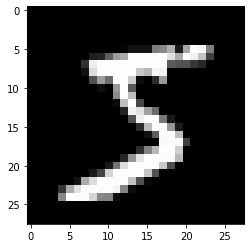

In [64]:
plt.imshow(content_train[0,:,:])

In [65]:
content_train.shape

(60000, 28, 28, 3)

In [66]:
content_train.shape

(60000, 28, 28, 3)

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
from pathlib import Path

In [69]:
filepath = Path('/content/drive/My Drive/data/svhn_cropped')

In [70]:
testdata = filepath / 'test.npy'
traindata = filepath / 'train.npy'

if testdata.is_file() and traindata.is_file():
    print ("File exist")
    style_raw_train = np.load(traindata)
    style_raw_test = np.load(testdata)

else:
    print ("File not exist")

    style_raw_train, style_raw_test = tfds.as_numpy(tfds.load(
    'svhn_cropped',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=False))
    
    style_raw_train = style_raw_train['image']
    style_raw_test = style_raw_test['image']

File exist


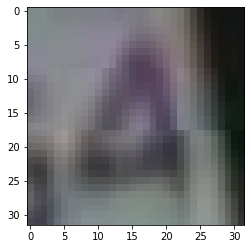

In [71]:
plt.imshow(style_raw_train[0])

In [72]:
#training
# delete 2 pixels from top and bottom
style_train = np.delete(style_raw_train, slice(29, 31), 1)
style_train = np.delete(style_train, slice(0, 2), 1)
# delete 2 pixels from left and right
style_train = np.delete(style_train, slice(29, 31), 2)
style_train = np.delete(style_train, slice(0, 2), 2)

#test
# delete 2 pixels from top and bottom
style_test = np.delete(style_raw_test, slice(29, 31), 1)
style_test = np.delete(style_test, slice(0, 2), 1)
# delete 2 pixels from left and right
style_test = np.delete(style_test, slice(29, 31), 2)
style_test = np.delete(style_test, slice(0, 2), 2)

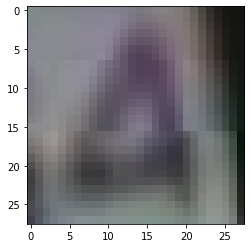

In [73]:
plt.imshow(style_train[0])

In [74]:
#make 60000 samples
n = 60000

index = np.random.choice(style_train.shape[0], n, replace=False) 

style_train = style_train[index]

In [75]:
style_train.shape
#style_train[0].shape

(60000, 28, 28, 3)

In [76]:
# reshape to (28, 28, 1), adding 1 to last dimension
image_size = style_train.shape[1]

# normalize input images
style_train = style_train.astype('float32') / 255
style_test = style_test.astype('float32') / 255

content_train = content_train.astype('float32') / 255
content_test = content_test.astype('float32') / 255

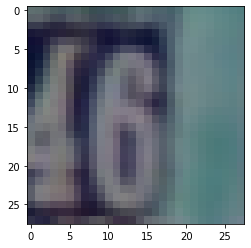

In [77]:
plt.imshow(style_train[0])



```
# This is formatted as code
```

# Training the Feature Extractor

#### Encoder

In [78]:
# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 128

In [79]:
# first build the encoder model
input_img = Input(shape=input_shape, name='encoder_input')

x = Conv2D(16, (3, 3), activation='relu', padding='same', name='en_conv16_1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='en_maxpool_1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='en_conv8_1')(x)
x = MaxPooling2D((2, 2), padding='same', name='en_maxpool_2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='en_conv8_2')(x)

encoded = MaxPooling2D((2, 2), padding='same', name='en_maxpool_3')(x)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 3)]       0         
_________________________________________________________________
en_conv16_1 (Conv2D)         (None, 28, 28, 16)        448       
_________________________________________________________________
en_maxpool_1 (MaxPooling2D)  (None, 14, 14, 16)        0         
_________________________________________________________________
en_conv8_1 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
en_maxpool_2 (MaxPooling2D)  (None, 7, 7, 8)           0         
_________________________________________________________________
en_conv8_2 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
en_maxpool_3 (MaxPooling2D)  (None, 4, 4, 8)           0   

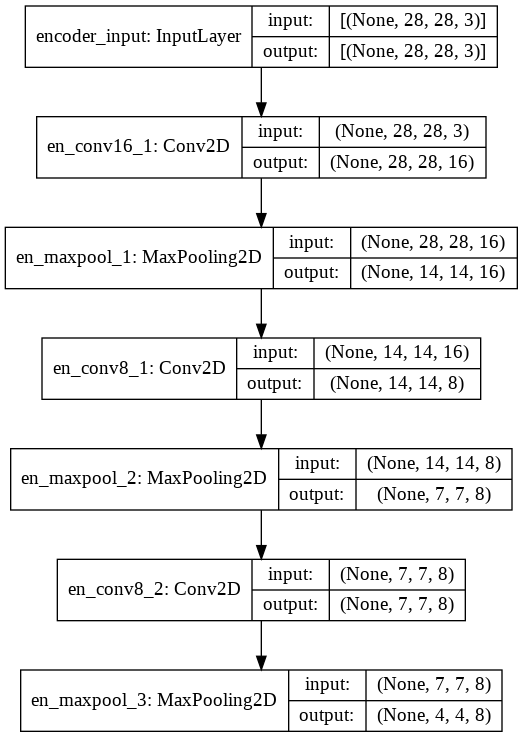

In [80]:
encoder = Model(input_img, encoded, name='encoder')

encoder.summary()
plot_model(encoder, show_shapes=True)

In [81]:
# This is feature extractor to feed into ADAIN after training the encoder
# To do: make this Extractor into an encoder with untrainable parameters to be connected to adain
#output_layers = [encoder.get_layer(layer_name) for layer_name in ['conv2d', 'conv2d_1', 'conv2d_2']]
#extractor = Model(inputs=encoder.inputs,                       outputs=[layer.output for layer in output_layers])
#features = extractor(content_test)

#### Decoder

In [82]:
encoded_shape = K.int_shape(encoded[0])

decoder_input = Input(shape=encoded_shape, name='decoder_input')

x = Conv2D(8, (3, 3), activation='relu', padding='same', name='dec_conv8_1')(decoder_input)
x = UpSampling2D((2, 2), name='dec_upsample_1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='dec_conv8_2')(x)
x = UpSampling2D((2, 2), name='dec_upsample_2')(x)
x = Conv2D(16, (3, 3), activation='relu', name='dec_conv16_1')(x)
x = UpSampling2D((2, 2), name='dec_upsample_3')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='dec_conv3_1')(x)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 4, 4, 8)]         0         
_________________________________________________________________
dec_conv8_1 (Conv2D)         (None, 4, 4, 8)           584       
_________________________________________________________________
dec_upsample_1 (UpSampling2D (None, 8, 8, 8)           0         
_________________________________________________________________
dec_conv8_2 (Conv2D)         (None, 8, 8, 8)           584       
_________________________________________________________________
dec_upsample_2 (UpSampling2D (None, 16, 16, 8)         0         
_________________________________________________________________
dec_conv16_1 (Conv2D)        (None, 14, 14, 16)        1168      
_________________________________________________________________
dec_upsample_3 (UpSampling2D (None, 28, 28, 16)        0   

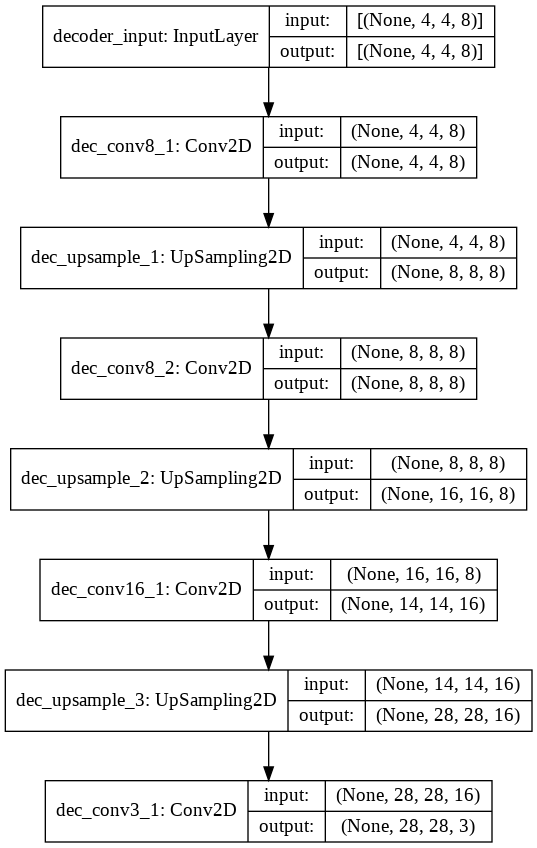

In [83]:
decoder = Model(decoder_input, decoded, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)

#### Autoencoder Instance

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 4, 4, 8)           2192      
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 3)         2771      
Total params: 4,963
Trainable params: 4,963
Non-trainable params: 0
_________________________________________________________________


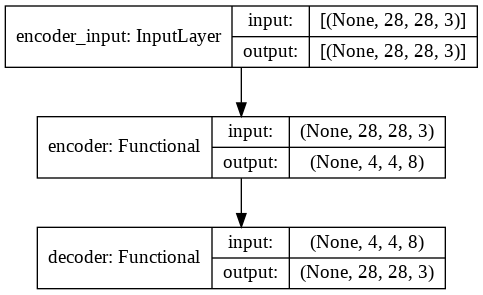

In [84]:
autoencoder = Model(input_img,decoder(encoder(input_img)),name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, show_shapes=True)


#### Autoencoder Training

In [85]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

autoencoder.fit(style_train,
                style_train,
                epochs=10,
                shuffle=True,
                batch_size=batch_size,
                validation_data=(style_test, style_test))

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 0.6454 - val_loss: 0.5985
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6189 - val_loss: 0.5948
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6163 - val_loss: 0.5930
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.6149 - val_loss: 0.5920
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6142 - val_loss: 0.5915
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6135 - val_loss: 0.5911
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6130 - val_loss: 0.5906
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6132 - val_loss: 0.5903
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6127 - val_loss: 0.5899
Epoch 10/10
469/469 [==============================] - 3s 7ms/step - loss: 0.6118 - val_loss: 0.5895

# Training the Styler

#### Styler Input

In [86]:
# place holders for inputs
content_input = Input(shape=input_shape, name='content_input')
style_input = Input(shape=input_shape, name='style_input')


In [87]:
# Freezing the encoder after training from Feature Extractor
for l in encoder.layers:
  l.trainable = False

In [88]:
# forwarding
content_features = encoder(content_input)
style_features = encoder(style_input)

#### Adaptive Instance Normalization

In [89]:
def adain(x, epsilon=1e-5):
    content = x[0]
    style = x[1]

    meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
    meanS, varS = tf.nn.moments(style,   [1, 2], keepdims=True)

    sigmaC = tf.sqrt(tf.add(varC, epsilon))
    sigmaS = tf.sqrt(tf.add(varS, epsilon))
    
    return (content - meanC) * sigmaS / sigmaC + meanS

In [90]:
normalized_feature = adain([content_features[-1], style_features[-1]])


#### Styler Decoder

In [91]:
#normalized_shape = tf.expand_dims(normalized_feature, axis=0)
normalized_shape = K.int_shape(normalized_feature)

In [92]:
decoder_input = Input(shape=normalized_shape, name='decoder_input')

In [93]:
# Instantiate new decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='stydec_conv8_1')(decoder_input)
x = UpSampling2D((2, 2), name='stydec_upsample_1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='stydec_conv8_2')(x)
x = UpSampling2D((2, 2), name='stydec_upsample_2')(x)
x = Conv2D(16, (3, 3), activation='relu', name='stydec_conv16_1')(x)
x = UpSampling2D((2, 2), name='stydec_upsample_3')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='stydec_conv3_1')(x)


Model: "styler_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 4, 4, 8)]         0         
_________________________________________________________________
stydec_conv8_1 (Conv2D)      (None, 4, 4, 8)           584       
_________________________________________________________________
stydec_upsample_1 (UpSamplin (None, 8, 8, 8)           0         
_________________________________________________________________
stydec_conv8_2 (Conv2D)      (None, 8, 8, 8)           584       
_________________________________________________________________
stydec_upsample_2 (UpSamplin (None, 16, 16, 8)         0         
_________________________________________________________________
stydec_conv16_1 (Conv2D)     (None, 14, 14, 16)        1168      
_________________________________________________________________
stydec_upsample_3 (UpSamplin (None, 28, 28, 16)     

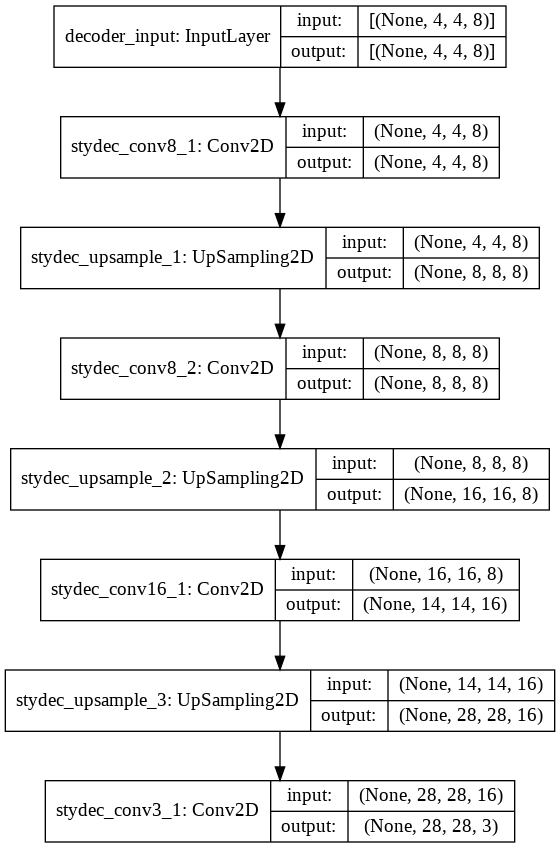

In [94]:
styler_decoder = Model(decoder_input, decoded, name='styler_decoder')
styler_decoder.summary()
plot_model(styler_decoder, show_shapes=True)

In [95]:
generated = styler_decoder(tf.expand_dims(normalized_feature, axis=0))

#### Losses

In [96]:
def mse_loss(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred))

def calculate_style_loss(x, epsilon=1e-5):
  y_true, y_pred = x
  loss = [
    mse_loss(K.mean(y_true, axis=(1, 2)), K.mean(y_pred, axis=(1, 2)))
  + mse_loss(K.sqrt(K.var(y_true, axis=(1, 2)) + epsilon), K.sqrt(K.var(y_pred, axis=(1, 2)) + epsilon))
  ]
  return K.sum(loss)

def calculate_content_loss(x):
  y_true, y_pred = x
  return mse_loss(y_true, y_pred)

In [114]:
# loss calculation
generated_features = encoder(generated)

content_loss = Lambda(calculate_content_loss, name='content_loss')([normalized_feature, generated_features[-1]])

style_loss = Lambda(calculate_style_loss, name='style_loss')([style_features, generated_features])

#total_loss =  content_loss + style_loss
#total_loss = Lambda(lambda x: x[0] + x[1], name='total_loss')([content_loss, style_loss])

total_loss = Lambda(lambda x: x[0], name='total_loss')([content_loss, style_loss])

#### Styler Instance

In [115]:
 # trainer
styler = Model(inputs=[content_input, style_input], outputs=[total_loss])
styler.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_input (InputLayer)      [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
style_input (InputLayer)        [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 4, 4, 8)      2192        content_input[0][0]              
                                                                 style_input[0][0]                
                                                                 styler_decoder[0][0]             
____________________________________________________________________________________________

#### Styler Training

In [119]:
#styler.compile(optimizer='adam', loss=lambda _, y_pred: y_pred)

styler.compile(optimizer='adam', loss=lambda _, y_pred: y_pred)

In [120]:
styler.fit([content_train,
                style_train],
                epochs=1,
                shuffle=True, batch_size=batch_size)

ValueError: ignored

# Plotting the results

In [122]:
encoded_imgs = encoder.predict(content_test)
decoded_imgs = decoder.predict(encoded_imgs)
content_test[0].shape

(28, 28, 3)

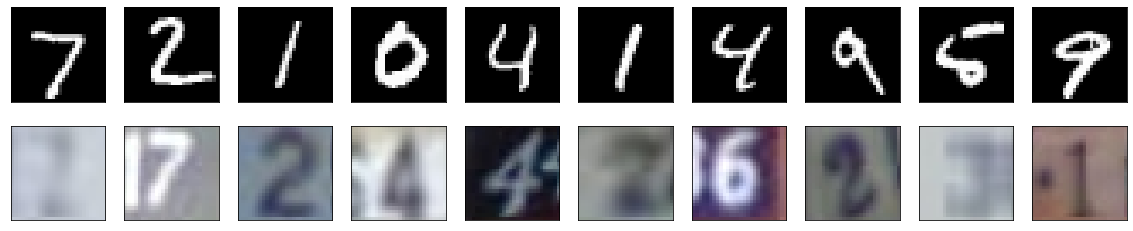

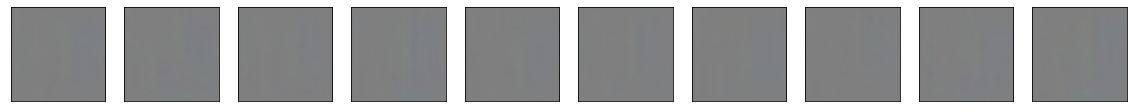

In [ ]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display Content
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(content_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Style
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(style_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()